In [ ]:
! pip install Ninja
! git clone https://github.com/NVlabs/stylegan3.git

import os
os.chdir("/content/stylegan3")

import click
import dnnlib
import h5py
import torch
import numpy as np
import PIL.Image
from gen_images import make_transform
from scipy import sparse, stats
from scipy.stats import t, zscore
from scipy.ndimage import interpolation
from sklearn.linear_model import LinearRegression
import legacy
import matplotlib.pyplot as plt
import pickle


device = torch.device('cuda')
network_pkl = "/content/stylegan3-r-ffhq-1024x1024.pkl"
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore
label = torch.zeros([1, G.c_dim], device=device)

fatal: destination path 'stylegan3' already exists and is not an empty directory.


In [ ]:
# Randomly sample latents
z_te = np.random.RandomState(7).randn(100, G.z_dim)
z_tr = np.random.RandomState(6).randn(4000, G.z_dim)

In [ ]:
# # Test set
# for i in range(z_te.shape[0]):
#     img = G(torch.from_numpy(z_te[None, i]).to(device), label, truncation_psi=0.7, noise_mode="none")
#     img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
#     image = PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')
#     image.save("/content/test/%s.png" % str(i+1).zfill(4))

# # Training set
# for i in range(z_tr.shape[0]):
#     img = G(torch.from_numpy(z_tr[None, i]).to(device), label, truncation_psi=0.7, noise_mode="none")
#     img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
#     image = PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')
#     image.save("/content/training/%s.png" % str(i+1).zfill(4))

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


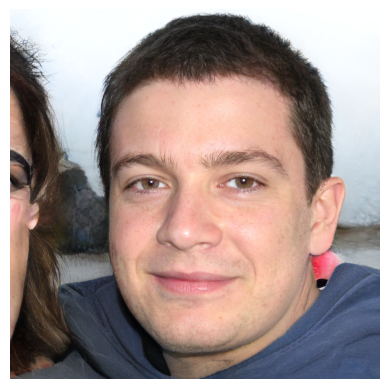

In [ ]:
# Example from test set
img = G(torch.from_numpy(z_te[None, 0]).to(device), label, truncation_psi=0.7, noise_mode="none")
img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
image = PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')
plt.figure()
plt.imshow(image)
plt.axis("off")
plt.show()

In [ ]:
w_te = np.zeros((100, 16, 512))
for i in range(100):
    _w = G.mapping(torch.from_numpy(z_te[None, i]).to(device), label, truncation_psi=0.7)
    w_te[i] = _w.cpu().numpy()
    # img = G.synthesis(w, noise_mode="none")

w_tr = np.zeros((4000, 16, 512))
for i in range(4000):
    _w = G.mapping(torch.from_numpy(z_tr[None, i]).to(device), label, truncation_psi=0.7)
    w_tr[i] = _w.cpu().numpy()
    # img = G.synthesis(w, noise_mode="none")

# Save the feature-disentangled w-latents
w = {'train': w_tr[:, 0].astype("float32"), 'test': w_te[:, 0].astype("float32")}
with open('StyleGAN_XL_w.pickle', 'wb') as handle:
    pickle.dump(w, handle, protocol=pickle.HIGHEST_PROTOCOL)
w['train'].shape, w['test'].shape

((4000, 512), (100, 512))